# Continuous Bag of Words

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import pickle
import string
import requests
import collections
import io
import tarfile
import urllib.request
from nltk.corpus import stopwords

In [3]:
session = tf.Session()

In [4]:
def load_movies_data():
    save_folder_name = "../../datasets/movies_data"
    pos_file = os.path.join(save_folder_name, 'rt-polarity.pos')
    neg_file = os.path.join(save_folder_name, 'rt-polarity.neg')
    
    if os.path.exists(save_folder_name):
        ## Podemos cargar la info directamente desde el PC
        pos_data = []
        with open(pos_file, 'r') as temp_pos_file:
            for row in temp_pos_file:
                pos_data.append(row)
                
        neg_data = []
        with open(neg_file, 'r') as temp_neg_file:
            for row in temp_neg_file:
                neg_data.append(row)
        
    else:
        ## Debemos descargar los ficheros de internet y guardarlos en esta carpeta
        url = "http://www.cs.cornell.edu/people/pabo/movie-review-data/rt-polaritydata.tar.gz"
        stream_data = urllib.request.urlopen(url)
        tmp = io.BytesIO()
        while True:
            s = stream_data.read(16384)
            if not s: 
                break
            tmp.write(s)
        stream_data.close()
        tmp.seek(0)
        
        tar_file = tarfile.open(fileobj=tmp, mode='r:gz')
        pos = tar_file.extractfile('rt-polaritydata/rt-polarity.pos')
        neg = tar_file.extractfile('rt-polaritydata/rt-polarity.neg')
        
        pos_data = []
        for line in pos:
            pos_data.append(line.decode('ISO-8859-1').encode('ascii', errors='ignore').decode())
            
        neg_data = []
        for line in neg:
            neg_data.append(line.decode('ISO-8859-1').encode('ascii', errors='ignore').decode())
            
        tar_file.close()
        
        if not os.path.exists(save_folder_name):
            os.makedirs(save_folder_name)
        with open(pos_file, 'w') as pos_file_handler:
            pos_file_handler.write(''.join(pos_data))
        with open(neg_file, 'w') as neg_file_handler:
            neg_file_handler.write(''.join(neg_data))
    
    texts = pos_data + neg_data
    target = [1]*len(pos_data) + [0]*len(neg_data)
    return (texts, target)         

In [5]:
def normalize_text(texts, stops):
    texts = [x.lower() for x in texts]
    texts = [''.join(c for c in x if c not in string.punctuation) for x in texts]
    texts = [''.join(c for c in x if c not in '0123456789') for x in texts]
    texts = [' '.join(word for word in x.split() if word not in (stops)) for x in texts]
    texts = [' '.join(x.split()) for x in texts]
    return texts

In [6]:
def build_dictionary(sentences, vocabulary_size):
    split_sentences = [s.split() for s in sentences]
    words = [x for sublist in split_sentences for x in sublist]
    count = [['RARE', -1]]
    count.extend(collections.Counter(words).most_common(vocabulary_size-1))
    word_dict = {}
    for word, word_count in count:
        word_dict[word] = len(word_dict)
    return word_dict

In [7]:
def text_to_numbers(sentences, word_dict):
    data = []
    for sentence in sentences:
        sentence_data = []
        for word in sentence:
            if word in word_dict:
                word_ix = word_dict[word]#posición/ID de la palabra en el word dict
            else:
                word_ix = 0 ##posición/ID de la palabra RARE
            sentence_data.append(word_ix)
        data.append(sentence_data)
    return data

In [27]:
def generate_batch_data(sentences, batch_size, window_size, method = 'skip_gram'):
    '''
        Skip Gram: Mi perro come su comida -> (Mi, come), (perro, come), (su, come), (comida, come)
        Cbow: Mi perro come su comida -> ([Mi,perro,su,comida]; come)
    '''
    batch_data = []
    label_data = []
    
    while len(batch_data) < batch_size:
        rand_sentences = np.random.choice(sentences)
        window_seq = [rand_sentences[max((ix-window_size),0):(ix+window_size+1)] 
                      for ix, x in enumerate(rand_sentences)]
        label_idx = [ix if ix < window_size else window_size for ix, x in enumerate(window_seq)]
        
        if method == 'skip_gram':
            batch_and_labels = [(x[y], x[:y]+x[(y+1):]) for x,y in zip(window_seq, label_idx)]
            # Convertir el dato a una lista de tuplas (palabra objetivo, contexto)
            tuple_data = [(x,y_) for x, y in batch_and_labels for y_ in y]
            batch, labels = [list(x) for x in zip(*tuple_data)]

        elif method=='cbow':
            batch_and_labels = [(x[:y]+x[(y+1):], x[y]) for x,y in zip(window_seq, label_idx)]
            # Conservar las ventanas de tamaño 2*window_size
            batch_and_labels = [(x,y) for x,y in batch_and_labels if len(x)==2*window_size]
            
            if len(batch_and_labels) <1:
                continue
            
            batch, labels = [list(x) for x in zip(*batch_and_labels)]
            
        else:
            raise ValueError("Método {} no implementado".format(method))
        
        batch_data.extend(batch[:batch_size])
        label_data.extend(labels[:batch_size])
        
    batch_data = batch_data[:batch_size]
    label_data = label_data[:batch_size]
    
    batch_data = np.array(batch_data)
    label_data = np.transpose(np.array([label_data]))
    
    return (batch_data, label_data)

In [9]:
batch_size = 500
embedding_size = 200
vocabulary_size = 2000
generations = 10000
model_learning_rate = 0.001
num_sampled = int(batch_size/2)
window_size = 3

save_embeddings_every = 500
print_valid_every = 1000
print_loss_every = 200

stops = stopwords.words('english')
valid_words = ['love', 'hate', 'happy', 'sad', 'man', 'woman']

In [10]:
texts, target = load_movies_data()
texts = normalize_text(texts, stops)

In [11]:
word_dictionary = build_dictionary(texts, vocabulary_size)
word_dictionary_rev = dict(zip(word_dictionary.values(), word_dictionary.keys()))
text_data = text_to_numbers(texts, word_dictionary)
valid_examples = [word_dictionary[x] for x in valid_words]

In [12]:
print(valid_words)
print(valid_examples)

['love', 'hate', 'happy', 'sad', 'man', 'woman']
[28, 945, 828, 362, 133, 564]


### Entrenar el modelo

In [13]:
embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
x_inputs = tf.placeholder(tf.int32, shape = [batch_size, 2*window_size])
y_target = tf.placeholder(tf.int32, shape = [batch_size, 1])
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

In [14]:
embed = tf.zeros([batch_size, embedding_size])
for element in range(2*window_size):
    embed += tf.nn.embedding_lookup(embeddings, x_inputs[:, element])

In [16]:
nce_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size], 
                                              stddev=1.0/np.sqrt(embedding_size)))
nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

In [17]:
loss = tf.reduce_mean(tf.nn.nce_loss(weights=nce_weights, biases=nce_biases,
                                    inputs=embed, labels=y_target, 
                                     num_sampled = num_sampled, num_classes=vocabulary_size))

In [18]:
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings),1, keepdims=True))
normalized_embeddings = embeddings/norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

In [19]:
saver = tf.train.Saver({"embeddings": embeddings})

In [20]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=model_learning_rate).minimize(loss)

In [21]:
init = tf.global_variables_initializer()
session.run(init)

In [29]:
loss_vect = []
loss_x_vect = []

for i in range(generations):
    batch_inputs, batch_labels = generate_batch_data(text_data, batch_size, window_size, method='cbow')
    feed_dict = {x_inputs: batch_inputs, y_target: batch_labels}
    session.run(optimizer, feed_dict=feed_dict)
    
    if (i+1) % print_loss_every == 0:
        loss_val = session.run(loss, feed_dict=feed_dict)
        loss_vect.append(loss_val)
        loss_x_vect.append(i+1)
        print("Iteración {}, Pérdida: ".format(i+1, loss_val))
    
    ## Validación del contexto, imprimiremos algunas palabras aleatorias y su top 5
    if (i+1) % print_valid_every == 0:
        sim = session.run(similarity, feed_dict=feed_dict)
        for j in range(len(valid_words)):
            valid_word = word_dictionary_rev[valid_examples[j]]
            top_k = 5
            nearest = (-sim[j,:]).argsort()[1:top_k+1]
            log_string = "Palabras cercanas a {}:".format(valid_word)
            for k in range(top_k):
                close_word = word_dictionary_rev[nearest[k]]
                log_string = "%s %s, "%(log_string, close_word)
            print(log_string)
    if (i+1) % save_embeddings_every == 0:
        #Guardar el vocabulario de palabras
        with open(os.path.join('../../datasets', 'movie_vocabulary.pkl'), 'wb') as f:
            pickle.dump(word_dictionary, f)
        #Guardar los embeddings
        model_checkpoint_path = os.path.join("../../datasets", "cbow_movie_embeddings.ckpt")
        save_path = saver.save(session, model_checkpoint_path)
        print("Modelo guardado en el fichero: {}".format(save_path))

Iteración 200, Pérdida: 
Iteración 400, Pérdida: 
Modelo guardado en el fichero: ../../datasets/cbow_movie_embeddings.ckpt
Iteración 600, Pérdida: 
Iteración 800, Pérdida: 
Iteración 1000, Pérdida: 
Palabras cercanas a love: elements,  appears,  poem,  notion,  quietly, 
Palabras cercanas a hate: pop,  wedding,  uses,  tasty,  romance, 
Palabras cercanas a happy: save,  hold,  motion,  flair,  sick, 
Palabras cercanas a sad: pianist,  playful,  pacing,  onscreen,  pointless, 
Palabras cercanas a man: shes,  debut,  vulgar,  machine,  least, 
Palabras cercanas a woman: makers,  crimes,  teens,  candy,  getting, 
Modelo guardado en el fichero: ../../datasets/cbow_movie_embeddings.ckpt
Iteración 1200, Pérdida: 
Iteración 1400, Pérdida: 
Modelo guardado en el fichero: ../../datasets/cbow_movie_embeddings.ckpt
Iteración 1600, Pérdida: 
Iteración 1800, Pérdida: 
Iteración 2000, Pérdida: 
Palabras cercanas a love: elements,  appears,  poem,  notion,  quietly, 
Palabras cercanas a hate: pop,  

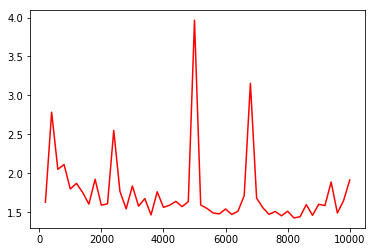

In [32]:
plt.plot(loss_x_vect, loss_vect, 'r-', label="Función de pérdidas de CBOW")